## PRIMER ANÁLISIS CON TODOS LOS DATOS.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
data = pd.read_csv("../outputs/house_fit.csv", index_col=0)

In [3]:
data.head()

,house_type_id,is_renewal_needed,is_new_development,m2,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
0,0,0,0,64.0,2,1.0,3.0,1,0,0,0,0,0,0,40.343263,-3.688352,85000
1,0,1,0,70.0,3,1.0,4.0,1,1,0,0,1,0,0,40.355109,-3.700105,129900
2,0,0,0,94.0,2,2.0,1.0,1,1,0,1,0,0,0,40.345539,-3.710970,144247
3,0,0,0,64.0,2,1.0,0.0,1,1,0,1,0,0,0,40.345539,-3.710970,109900
4,0,0,0,108.0,2,2.0,4.0,1,1,1,1,0,0,1,40.355841,-3.688399,260000


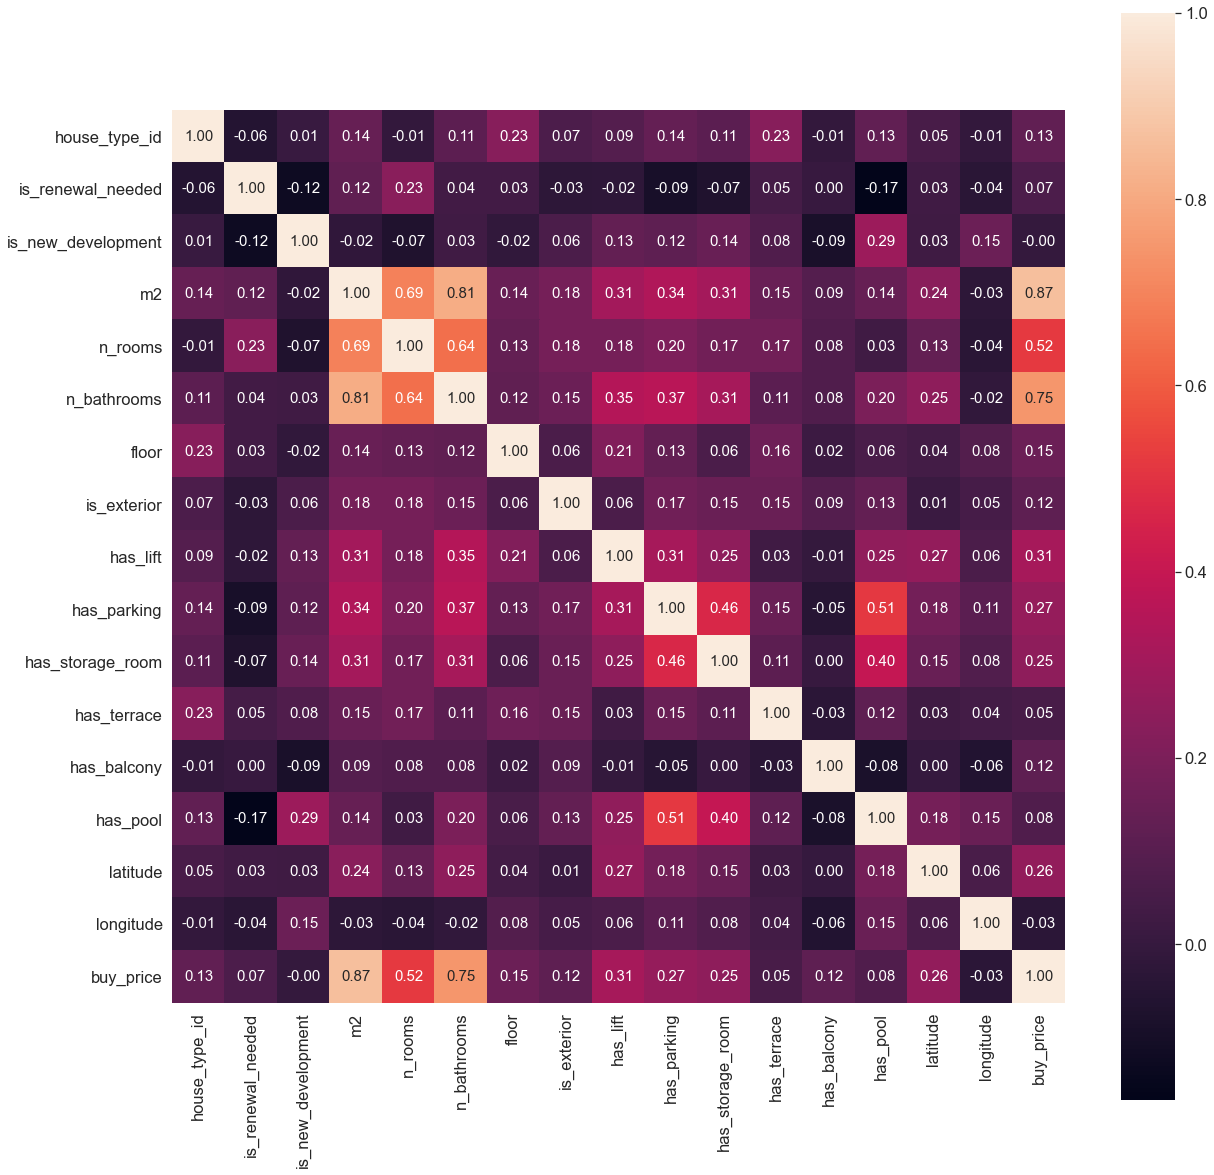

In [4]:
# Vamos a realizar un heatmap para ver la relación entre los datos.

cm = np.corrcoef(data.values.T)
sns.set(font_scale=1.5)
plt.figure(figsize=(20, 20))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 15},
                yticklabels=data.columns, xticklabels=data.columns)

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


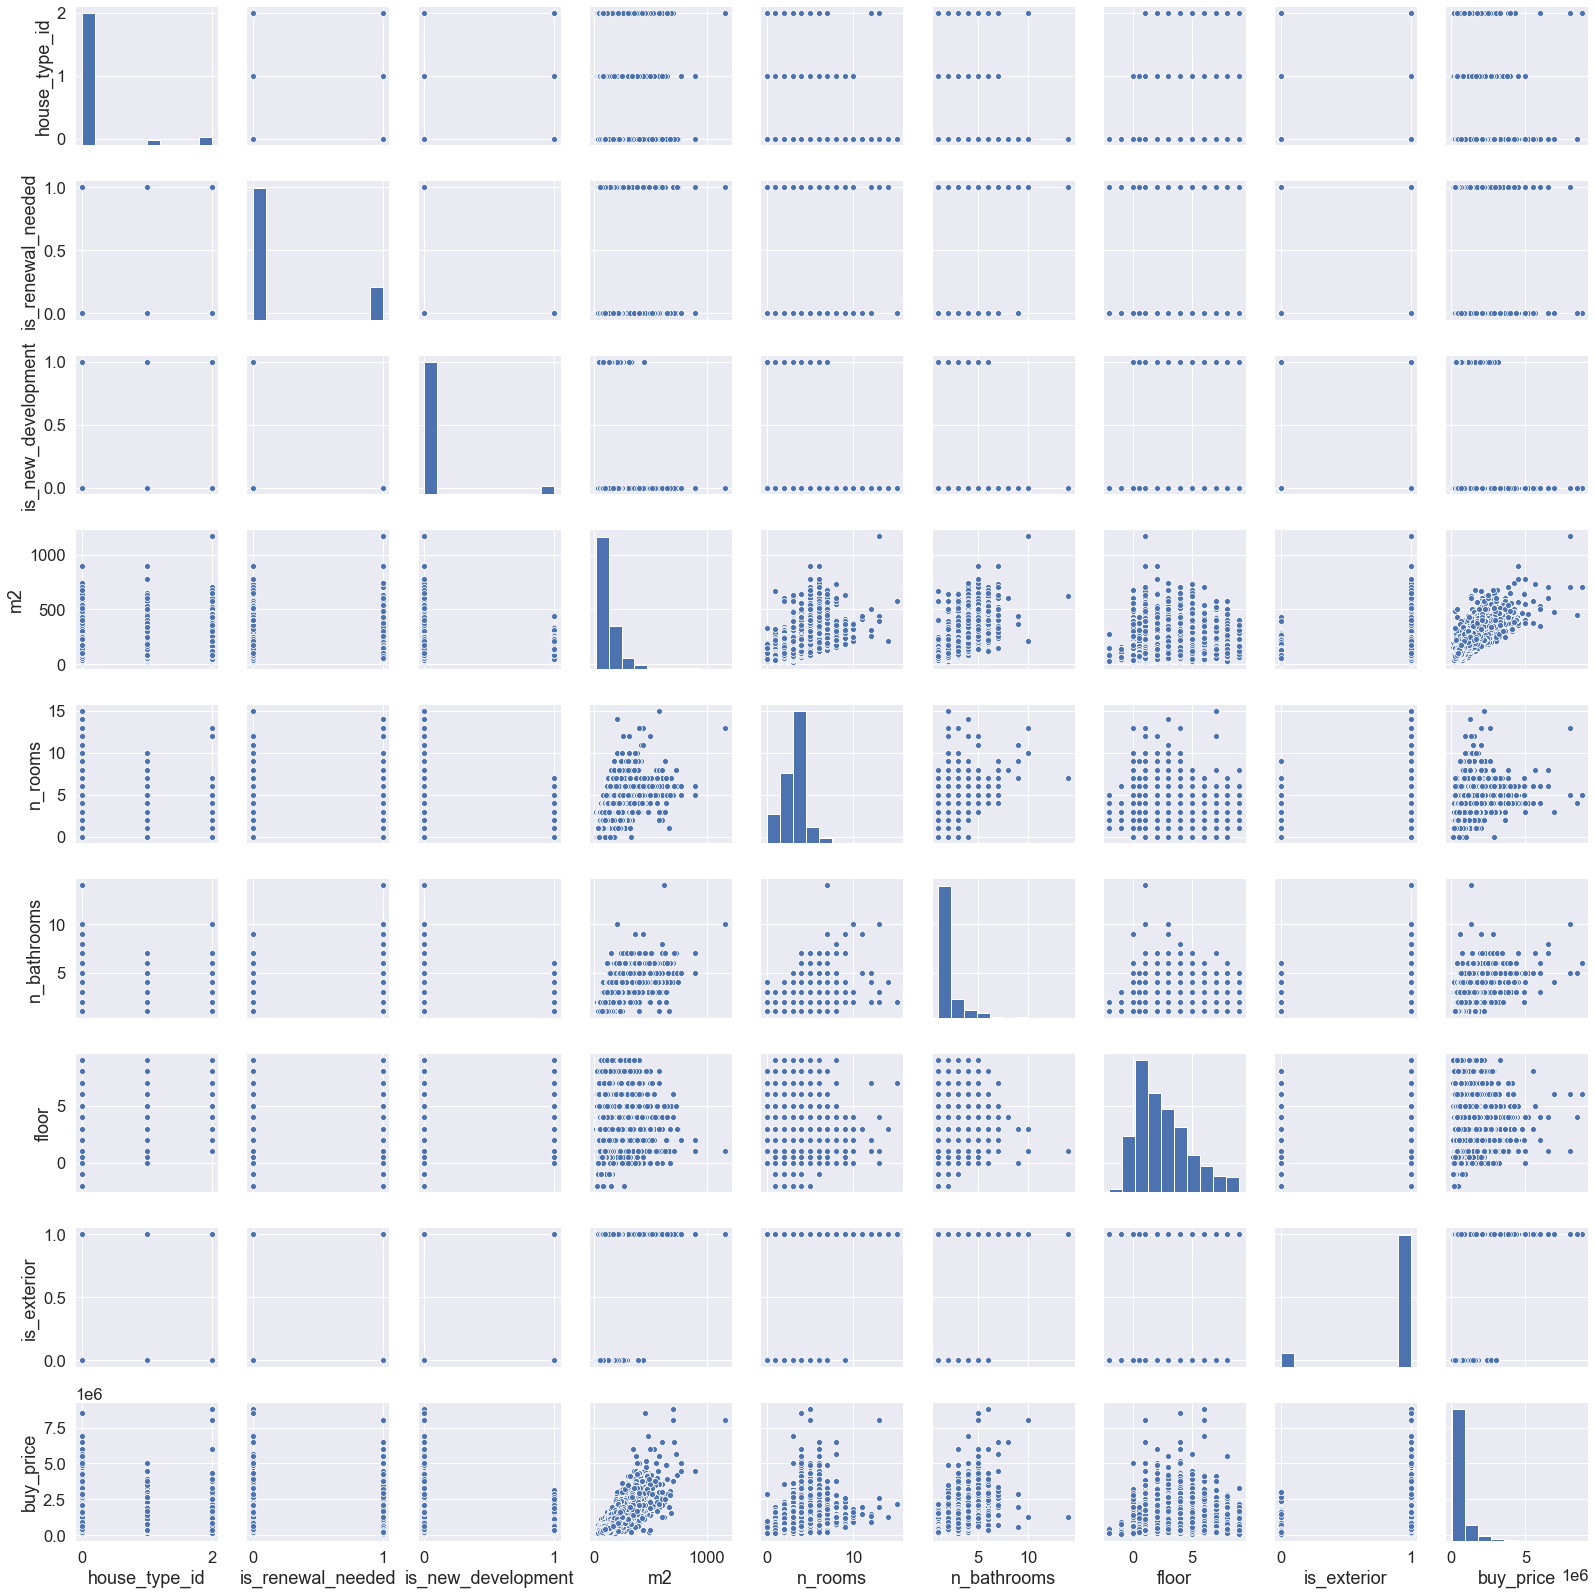

In [5]:
# Vamos a realizar ahora un pairplot para ver como se relacionan los datos entre sí.
# Como tenemos muchas features, vamos a dividirlas en dos análisis.

d_analysis_1 = data[["house_type_id", "is_renewal_needed", "is_new_development","m2", "n_rooms",
                    "n_bathrooms", "floor", "is_exterior", "buy_price"]]

sns.pairplot(data, size=2.5, vars=d_analysis_1)
plt.tight_layout()

/usr/local/lib/python3.8/site-packages/seaborn/axisgrid.py:2071: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


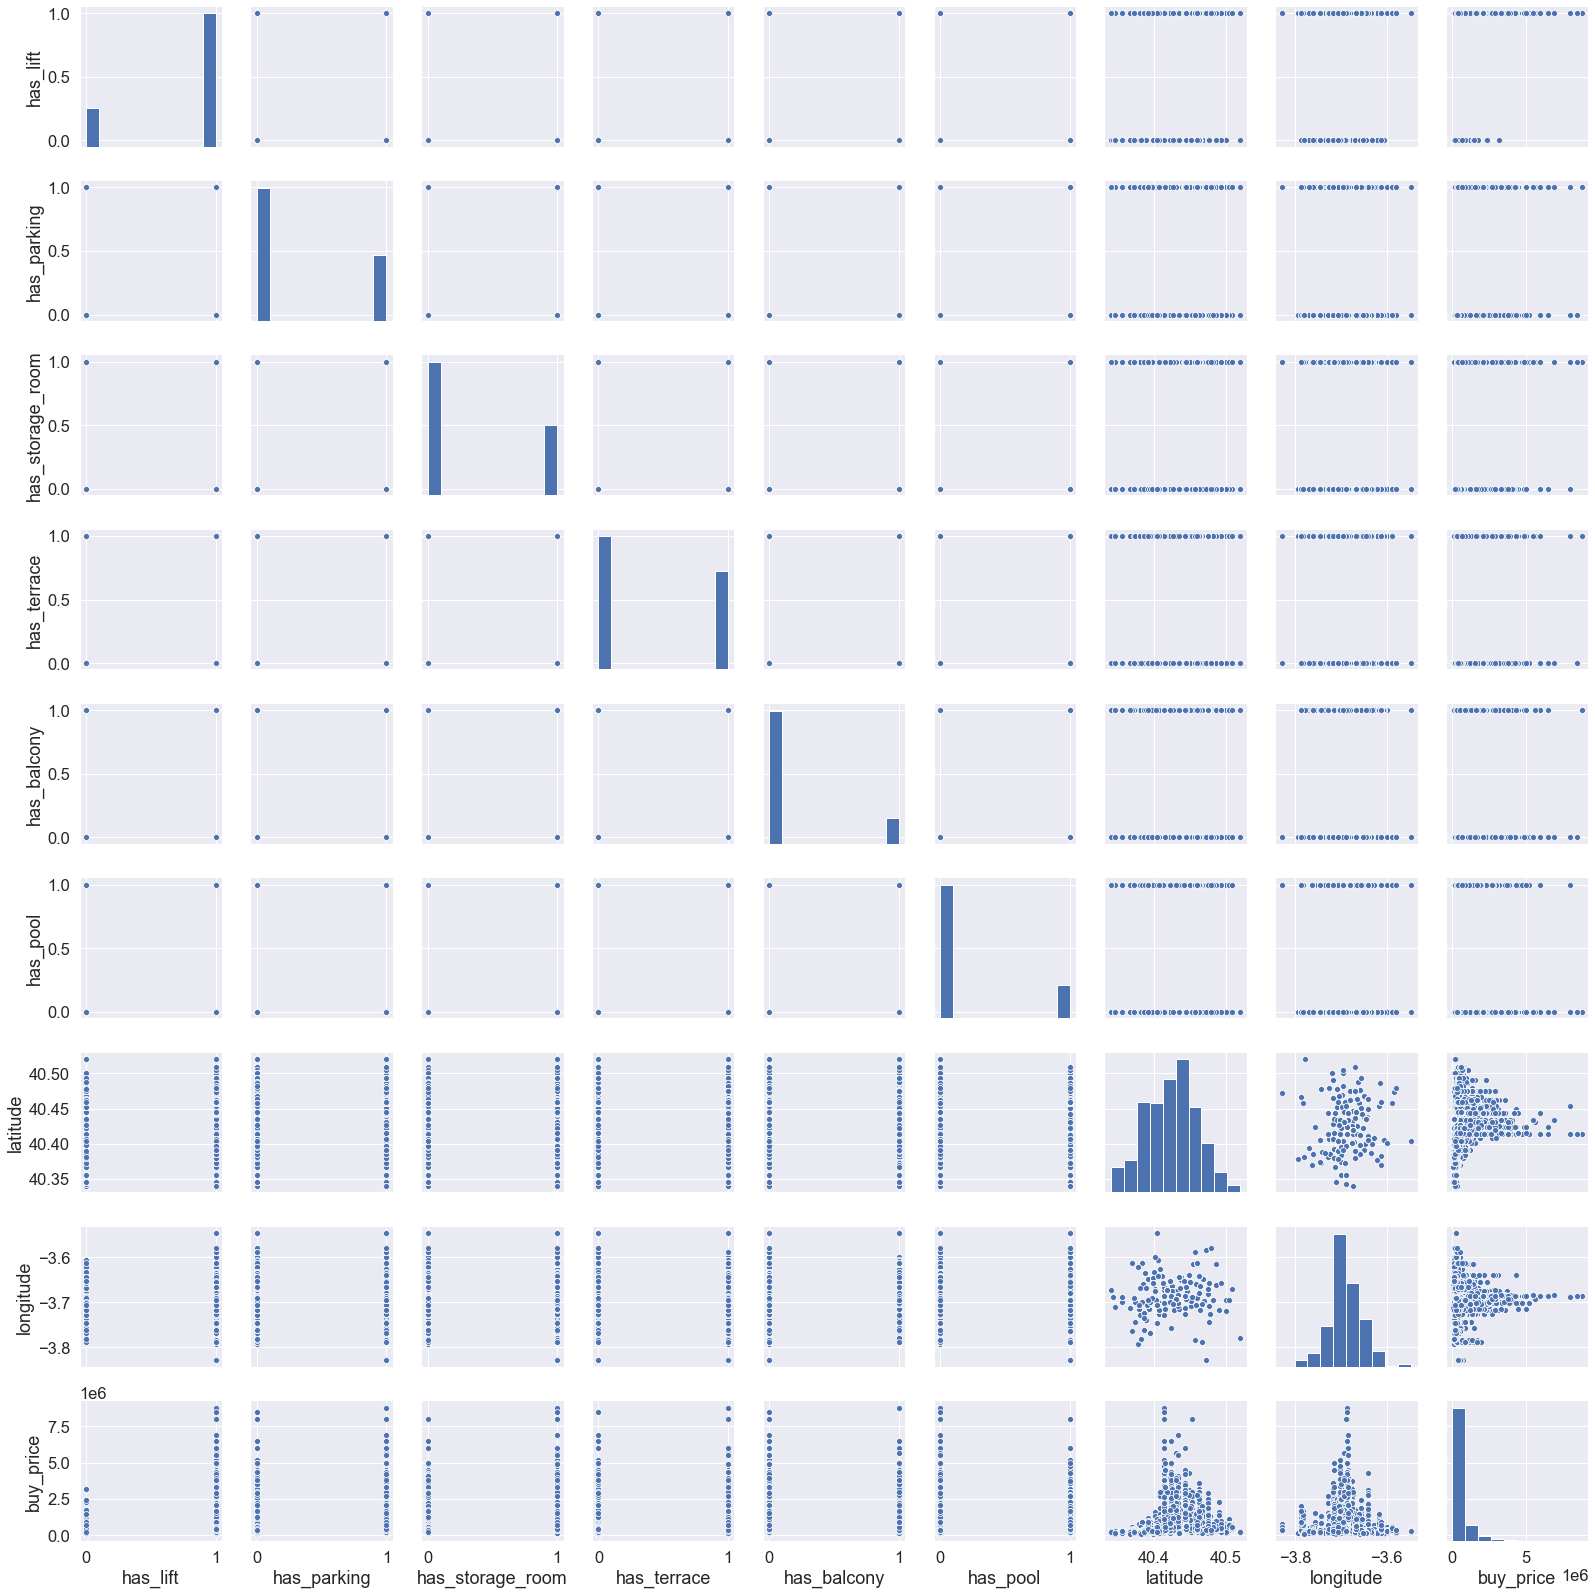

In [7]:
d_analysis_2 = data[["has_lift", "has_parking", "has_storage_room", "has_terrace",
              "has_balcony", "has_pool", "latitude", "longitude", "buy_price"]]

sns.pairplot(data, size=2.5, vars=d_analysis_2)
plt.tight_layout()

## Nos metemos ya de lleno con el entrenamiento de nuestro modelo.

### Empezaremos entrenando los datos con el módulo sklearn.

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, VotingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [10]:
X = data.drop(["buy_price"], axis=1)
y = data['buy_price']

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=7)

In [12]:
models = {"DecisionTree" : DecisionTreeRegressor(),
          "RandomForest": RandomForestRegressor(),
          "ExtraTrees" : ExtraTreesRegressor(),
          "GradientBoosting" : GradientBoostingRegressor(),
          "HistGradientBoosting": HistGradientBoostingRegressor(),
          "Voting": VotingRegressor(
              [('etr', ExtraTreesRegressor()),
               ('rf', RandomForestRegressor())]
          )
         }

In [13]:
# Entrenamos los datos

for name, model in models.items():
    print(f"Entrenando {name}")
    model.fit(X_train, y_train)
print("Entrenamiento finalizado")

Entrenando DecisionTree
Entrenando RandomForest
Entrenando ExtraTrees
Entrenando GradientBoosting
Entrenando HistGradientBoosting
Entrenando Voting
Entrenamiento finalizado


-------DecisionTree-------
RMSE 257470.518
R2 0.832
-------RandomForest-------
RMSE 198613.119
R2 0.9
-------ExtraTrees-------
RMSE 197511.651
R2 0.901
-------GradientBoosting-------
RMSE 212587.66
R2 0.886
-------HistGradientBoosting-------
RMSE 199173.027
R2 0.9
-------Voting-------
RMSE 190474.381
R2 0.908


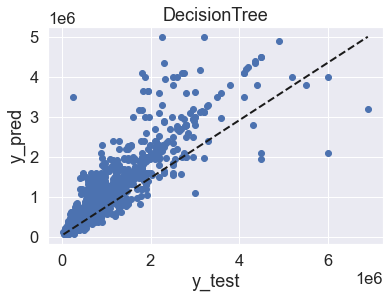

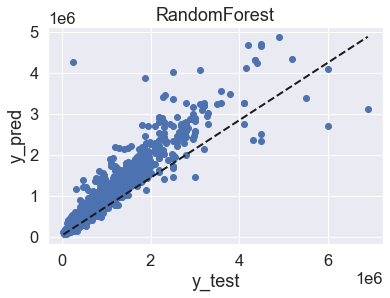

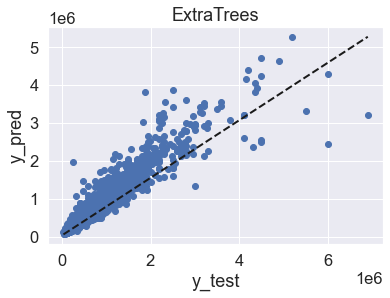

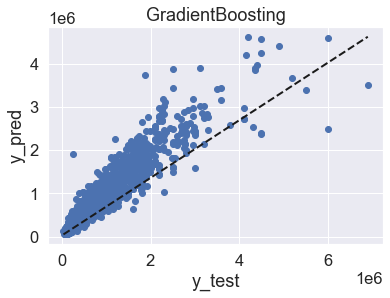

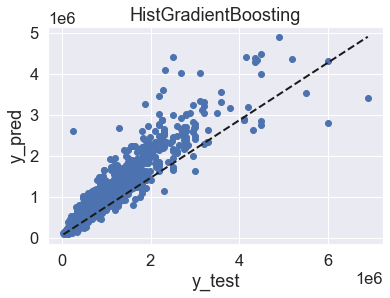

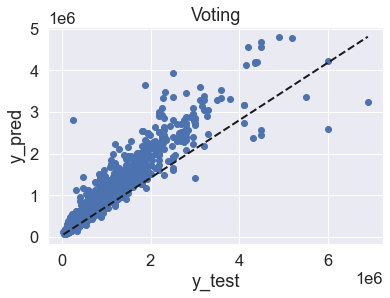

In [19]:
# Comprobamos el resultado de las métricas seleccionadas.

for name, model in models.items():
    y_pred = model.predict(X_test)
    print(f"-------{name}-------")
    print("RMSE", round(np.sqrt(mean_squared_error(y_test,y_pred)),3))
    print("R2", round(r2_score(y_test,y_pred),3))
    plt.figure()
    plt.title(name)
    plt.scatter(y_test,y_pred)
    plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
    plt.xlabel("y_test")
    plt.ylabel("y_pred")

In [15]:
# Aplicamos un crossvalidation para ver cual es el modelo que mejor funciona.

for name, model in models.items():
    scores = cross_val_score(model,X,y, cv=10)
    print(f"{name} accuracy{np.mean(scores)}")

DecisionTree accuracy0.683425657006503
RandomForest accuracy0.8339948072818176
ExtraTrees accuracy0.7927147929594299
GradientBoosting accuracy0.7070203101400898
HistGradientBoosting accuracy0.8256190389459366
Voting accuracy0.8248260141478564


In [22]:
# Como podemos comprobar, el modelo que mejores datos nos arroja es VotingRegressor.
# Estos datos no nos valen ya que tenemos un RMSE muy alto (190000 €) y R2 muy mejorable (0.908).
# Sin embargo a la hora de realizar el crossvalidation, observamos que el modelo que mejor resultado arroja
# es el RandomForest.
# Como podemos ver en las gráficas, tenemos una gran dispersión de los datos.

### Vamos a entrenar nuestros datos con el módulo xgboost,  para ver si mejoran los resultados.

In [26]:
from xgboost import XGBRegressor

RMSE 196543.643
R2 0.902


Text(0, 0.5, 'y_pred')

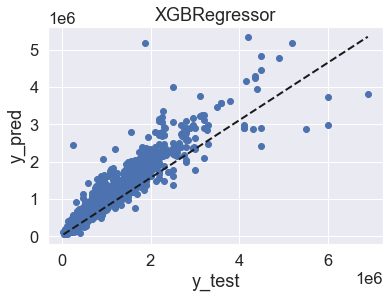

In [29]:
xgbr = XGBRegressor()
xgbr.fit(X_train, y_train)
y_pred = xgbr.predict(X_test)
print("RMSE", round(np.sqrt(mean_squared_error(y_test,y_pred)),3))
print("R2", round(r2_score(y_test,y_pred),3))

# Ploteamos las gráficas.
plt.figure()
plt.title("XGBRegressor")
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")

In [ ]:
# Nuestros datos no mejoran con este módulo.

### Vamos a entrenar ahora con el módulo H2O.

In [30]:
# Comprobamos ahora si con el módulo H2O obtenemos mejores resultados.
# Vamos a trabajar con cuatro modelos:
    # H2OAutoML
    # H2ORandomForestEstimator.
    # H2OGradientBoostingEstimator.
    # H2OXGBoostEstimator.

In [32]:
import h2o
from h2o.automl import H2OAutoML
from h2o.estimators import H2ORandomForestEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators import H2OXGBoostEstimator

h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321 . connected.


H2O_cluster_uptime:,1 day 1 hour 20 mins
H2O_cluster_timezone:,Europe/Madrid
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.30.1.3
H2O_cluster_version_age:,16 days
H2O_cluster_name:,H2O_from_python_Javi_geldd1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,633 Mb
H2O_cluster_total_cores:,4
H2O_cluster_allowed_cores:,4
H2O_cluster_status:,"locked, healthy"


#### H2OAutoML

In [33]:
h2train = h2o.H2OFrame(data)

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [34]:
X = list(data.drop(["buy_price"], axis=1))
y = "buy_price"

In [36]:
automl = H2OAutoML(max_runtime_secs=1200, sort_metric='RMSE')
automl.train(X, y, training_frame=h2train)
leader_board = automl.leaderboard
leader_board.head()

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id,rmse,mean_residual_deviance,mse,mae,rmsle
StackedEnsemble_AllModels_AutoML_20201015_121547,167433,2.80337e+10,2.80337e+10,73041.1,0.173985
StackedEnsemble_BestOfFamily_AutoML_20201015_121547,169669,2.87875e+10,2.87875e+10,74885.6,0.178141
GBM_grid__1_AutoML_20201015_121547_model_10,173647,3.01534e+10,3.01534e+10,78192.2,0.186448
GBM_grid__1_AutoML_20201015_121547_model_2,173857,3.02261e+10,3.02261e+10,74152.6,0.180451
GBM_grid__1_AutoML_20201015_121547_model_8,174365,3.04032e+10,3.04032e+10,76972,0.183049
GBM_grid__1_AutoML_20201015_121547_model_6,175388,3.07608e+10,3.07608e+10,78197.6,0.183111
GBM_1_AutoML_20201015_121547,176171,3.10364e+10,3.10364e+10,81935.8,0.190746
XGBoost_grid__1_AutoML_20201015_121547_model_13,177286,3.14304e+10,3.14304e+10,80748.9,0.191204
XGBoost_grid__1_AutoML_20201015_121547_model_3,177467,3.14946e+10,3.14946e+10,80030.2,0.188674
GBM_3_AutoML_20201015_121547,177667,3.15656e+10,3.15656e+10,80702.8,0.186877


#### Importamos ahora el csv para trabajar con el resto de modelos.

In [37]:
data = h2o.import_file("../outputs/house_fit.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [38]:
data.describe()

Rows:17398
Cols:18




,C1,house_type_id,is_renewal_needed,is_new_development,m2,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude,buy_price
type,int,int,int,int,int,int,int,real,int,int,int,int,int,int,int,real,real,int
mins,0.0,0.0,0.0,0.0,16.0,0.0,1.0,-2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,40.3399339,-3.828782660082676,36000.0
mean,8698.5,0.1408207839981607,0.19617197379009083,0.05851247269801126,124.4804000459823,2.8665363834923547,1.8732038165306357,2.652057707782503,0.9063110702379584,0.7769283825727095,0.33003793539487297,0.34492470398896424,0.424991378319347,0.16208759627543395,0.20048281411656513,40.42378312825517,-3.6889845663551566,566094.5436257041
maxs,17397.0,2.0,1.0,1.0,1165.0,15.0,14.0,9.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,40.520553799999995,-3.5466159,8800000.0
sigma,5022.514327173858,0.4749873512021809,0.39711156443925666,0.2347167011603802,86.35081354747794,1.2302377570715686,1.0332264578584647,2.0693414446916942,0.2914038349167505,0.41631794703886255,0.4702399455854934,0.4753573819070797,0.49435589767023785,0.3685417401418448,0.4003731621708535,0.03542530874583127,0.036761168206895206,614839.8999722311
zeros,1,15858,13985,16380,0,42,0,1829,1630,3881,11656,11397,10004,14578,13910,0,0,0
missing,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
0,0.0,0.0,0.0,0.0,64.0,2.0,1.0,3.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,40.34326305,-3.688352297394898,85000.0
1,1.0,0.0,1.0,0.0,70.0,3.0,1.0,4.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,40.3551089,-3.7001047141537535,129900.0
2,2.0,0.0,0.0,0.0,94.0,2.0,2.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,40.345538899999994,-3.7109697,144247.0


In [39]:
X = data.col_names[1:-1]
y = data.col_names[-1]

train, test =data.split_frame([0.8], seed=1234)
train.shape, test.shape

((13994, 18), (3404, 18))

#### H2ORandomForestEstimator

In [119]:
rf_h2o = H2ORandomForestEstimator()
rf_h2o.train(X, y, training_frame=train)
print(rf_h2o)

drf Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2ORandomForestEstimator :  Distributed Random Forest
Model Key:  DRF_model_python_1602665690260_60


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,4275814.0,20.0,20.0,20.0,6443.0,7266.0,6799.26




ModelMetricsRegression: drf
** Reported on train data. **

MSE: 35763227434.91622
RMSE: 189111.6797950783
MAE: 80820.16495084345
RMSLE: 0.19064576689819182
Mean Residual Deviance: 35763227434.91622

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-15 13:37:47,0.011 sec,0.0,NaN,NaN,NaN
1,,2020-10-15 13:37:47,0.326 sec,1.0,260135.640597,112191.920442,6.767055e+10
2,,2020-10-15 13:37:47,0.538 sec,2.0,260443.864991,113124.597603,6.783101e+10
3,,2020-10-15 13:37:47,0.667 sec,3.0,267521.391684,113103.636061,7.156770e+10
4,,2020-10-15 13:37:47,0.796 sec,4.0,262992.292816,110502.586122,6.916495e+10
5,,2020-10-15 13:37:48,0.951 sec,5.0,254612.822205,106232.408059,6.482769e+10
6,,2020-10-15 13:37:48,1.070 sec,6.0,242562.424223,101822.571994,5.883653e+10
7,,2020-10-15 13:37:48,1.198 sec,7.0,231722.728596,99660.288199,5.369542e+10
8,,2020-10-15 13:37:48,1.369 sec,8.0,226865.152122,97705.246371,5.146780e+10
9,,2020-10-15 13:37:48,1.485 sec,9.0,225471.875118,96893.973897,5.083757e+10



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m2,1.013430e+17,1.000000,0.500041
1,n_bathrooms,4.058315e+16,0.400453,0.200243
2,latitude,2.026788e+16,0.199993,0.100005
3,n_rooms,1.546047e+16,0.152556,0.076284
4,longitude,9.668417e+15,0.095403,0.047705
5,floor,3.981024e+15,0.039283,0.019643
6,has_parking,2.580896e+15,0.025467,0.012735
7,has_lift,2.283055e+15,0.022528,0.011265
8,house_type_id,1.196784e+15,0.011809,0.005905
9,has_storage_room,1.126061e+15,0.011111,0.005556


In [120]:
# Vamos a comprobar que no tenemos overfitting entre los datos entrenados y los datos del test.

# Datos entrenados.
print("-------train metrics-------")
print("RMSE: ", round(rf_h2o.rmse(),3))
print("R2: ", round(rf_h2o.r2(),3))

# Datos test.
print("-------test metrics-------")
print("RMSE: ", rf_h2o.model_performance(test).rmse())
print("R2: ", rf_h2o.model_performance(test).r2())

-------train metrics-------
RMSE:  189111.68
R2:  0.905
-------test metrics-------
RMSE:  157165.0756866244
R2:  0.935091957071013


In [ ]:
# Como podemos observar, existe un underfittig considerable.

In [121]:
predict = rf_h2o.predict(test)

drf prediction progress: |████████████████████████████████████████████████| 100%


Text(0, 0.5, 'y_pred')

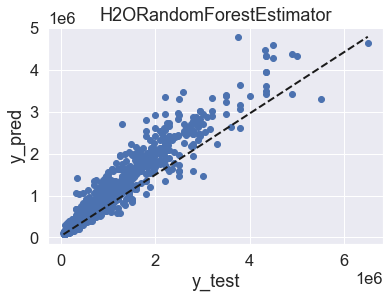

In [122]:
# Plots
y_pred = predict.as_data_frame()
y_test = test[-1].as_data_frame()
plt.figure()
plt.title("H2ORandomForestEstimator")
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")

In [ ]:
# Existe una gran dispersión de los datos.
# La gran mayoría de las viviendas están valoradas muy por encima de su precio.

In [123]:
print(predict, test[-1])

predict
121483
121082
110604
91974.4
166037
114780
135314
261294
104674
274704


buy_price
109900
118000
90000
89900
144900
110000
138000
280000
100000
275000


#### H2OGradientBoostingEstimator

In [124]:
gbm_h2o = H2OGradientBoostingEstimator()
gbm_h2o.train(X, y, training_frame=train)
print(gbm_h2o)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Model Details
H2OGradientBoostingEstimator :  Gradient Boosting Machine
Model Key:  GBM_model_python_1602665690260_61


Model Summary: 


,,number_of_trees,number_of_internal_trees,model_size_in_bytes,min_depth,max_depth,mean_depth,min_leaves,max_leaves,mean_leaves
0,,50.0,50.0,19887.0,5.0,5.0,5.0,14.0,32.0,26.94




ModelMetricsRegression: gbm
** Reported on train data. **

MSE: 27842273702.645664
RMSE: 166860.0422589113
MAE: 87701.12809619302
RMSLE: 0.21290337711157153
Mean Residual Deviance: 27842273702.645664

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-15 13:37:55,0.003 sec,0.0,614314.457897,396522.180487,3.773823e+11
1,,2020-10-15 13:37:55,0.046 sec,1.0,564850.810021,361172.704396,3.190564e+11
2,,2020-10-15 13:37:55,0.067 sec,2.0,520189.406782,329458.583775,2.705970e+11
3,,2020-10-15 13:37:56,0.096 sec,3.0,480703.923352,301284.428092,2.310763e+11
4,,2020-10-15 13:37:56,0.112 sec,4.0,446185.044507,276730.641369,1.990811e+11
5,,2020-10-15 13:37:56,0.126 sec,5.0,415538.654091,254828.636333,1.726724e+11
6,,2020-10-15 13:37:56,0.139 sec,6.0,387151.927906,235484.028097,1.498866e+11
7,,2020-10-15 13:37:56,0.150 sec,7.0,362295.584220,218406.281978,1.312581e+11
8,,2020-10-15 13:37:56,0.167 sec,8.0,340884.735664,203597.439530,1.162024e+11
9,,2020-10-15 13:37:56,0.181 sec,9.0,322462.679140,190364.452270,1.039822e+11



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m2,2.064254e+16,1.000000e+00,8.018219e-01
1,latitude,2.089425e+15,1.012194e-01,8.115990e-02
2,longitude,1.517381e+15,7.350746e-02,5.893989e-02
3,n_bathrooms,7.167519e+14,3.472207e-02,2.784092e-02
4,n_rooms,2.041435e+14,9.889456e-03,7.929582e-03
5,floor,1.694307e+14,8.207838e-03,6.581225e-03
6,has_lift,9.699786e+13,4.698930e-03,3.767705e-03
7,is_renewal_needed,7.657060e+13,3.709359e-03,2.974245e-03
8,house_type_id,6.348706e+13,3.075544e-03,2.466039e-03
9,has_pool,5.400090e+13,2.616000e-03,2.097566e-03


In [125]:
# Vamos a comprobar que no tenemos overfitting entre los datos entrenados y los datos del test.

# Datos entrenados.
print("-------train metrics-------")
print("RMSE: ", round(gbm_h2o.rmse(),3))
print("R2: ", round(gbm_h2o.r2(),3))

# Datos test.
print("-------test metrics-------")
print("RMSE: ", gbm_h2o.model_performance(test).rmse())
print("R2: ", gbm_h2o.model_performance(test).r2())

-------train metrics-------
RMSE:  166860.042
R2:  0.926
-------test metrics-------
RMSE:  178315.46412139133
R2:  0.9164465399460072


In [ ]:
# Como podemos observar, existe un poco de overfitting.

In [126]:
predict = gbm_h2o.predict(test)

gbm prediction progress: |████████████████████████████████████████████████| 100%


Text(0, 0.5, 'y_pred')

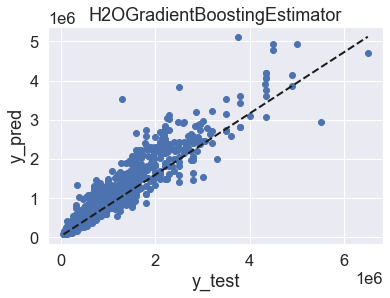

In [127]:
# Plots
y_pred = predict.as_data_frame()
y_test = test[-1].as_data_frame()
plt.figure()
plt.title("H2OGradientBoostingEstimator")
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")

In [ ]:
# Existe una gran dispersión de los datos.
# La gran mayoría de las viviendas están valoradas por encima de su precio.

In [128]:
print(predict, test[-1])

predict
140935
148963
131635
117079
190633
128552
138293
257749
124046
315695


buy_price
109900
118000
90000
89900
144900
110000
138000
280000
100000
275000


#### H2OXGBoostEstimator

In [145]:
xgbm_h2o = H2OXGBoostEstimator()
xgbm_h2o.train(X, y, training_frame=train)
print(xgbm_h2o)

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_model_python_1602665690260_66


Model Summary: 


,,number_of_trees
0,,50.0




ModelMetricsRegression: xgboost
** Reported on train data. **

MSE: 10616273217.650232
RMSE: 103035.30083253133
MAE: 60131.11827194727
RMSLE: 0.16388027116010148
Mean Residual Deviance: 10616273217.650232

Scoring History: 


,,timestamp,duration,number_of_trees,training_rmse,training_mae,training_deviance
0,,2020-10-15 13:52:45,0.010 sec,0.0,848461.692767,569652.357798,7.198872e+11
1,,2020-10-15 13:52:45,0.058 sec,1.0,622535.474226,400220.505421,3.875504e+11
2,,2020-10-15 13:52:45,0.085 sec,2.0,467127.307861,282144.335479,2.182079e+11
3,,2020-10-15 13:52:45,0.111 sec,3.0,360761.531894,202479.555832,1.301489e+11
4,,2020-10-15 13:52:45,0.135 sec,4.0,290615.412848,152864.564915,8.445732e+10
5,,2020-10-15 13:52:45,0.159 sec,5.0,244355.910497,124395.217315,5.970981e+10
6,,2020-10-15 13:52:45,0.188 sec,6.0,213539.611074,108483.982193,4.559917e+10
7,,2020-10-15 13:52:45,0.217 sec,7.0,193288.338049,98589.695546,3.736038e+10
8,,2020-10-15 13:52:45,0.252 sec,8.0,179565.973880,92122.393250,3.224394e+10
9,,2020-10-15 13:52:46,0.291 sec,9.0,170147.501350,88275.780275,2.895017e+10



See the whole table with table.as_data_frame()

Variable Importances: 


,variable,relative_importance,scaled_importance,percentage
0,m2,6.251164e+15,1.000000,0.803545
1,latitude,6.621546e+14,0.105925,0.085116
2,longitude,4.309269e+14,0.068935,0.055393
3,n_bathrooms,1.405351e+14,0.022481,0.018065
4,n_rooms,7.777557e+13,0.012442,0.009998
5,floor,7.557019e+13,0.012089,0.009714
6,is_renewal_needed,2.661772e+13,0.004258,0.003422
7,has_lift,2.580904e+13,0.004129,0.003318
8,house_type_id,2.479486e+13,0.003966,0.003187
9,is_new_development,1.522512e+13,0.002436,0.001957


In [146]:
# Vamos a comprobar que no tenemos overfitting entre los datos entrenados y los datos del test.

# Datos entrenados.
print("-------train metrics-------")
print("RMSE: ", round(xgbm_h2o.rmse(),3))
print("R2: ", round(xgbm_h2o.r2(),3))

# Datos test.
print("-------test metrics-------")
print("RMSE: ", xgbm_h2o.model_performance(test).rmse())
print("R2: ", xgbm_h2o.model_performance(test).r2())

-------train metrics-------
RMSE:  103035.301
R2:  0.973
-------test metrics-------
RMSE:  189632.60618225037
R2:  0.8977624360073131


In [147]:
# Como podemos observar, hay mucho overfittig.

In [132]:
predict = xgbm_h2o.predict(test)

xgboost prediction progress: |████████████████████████████████████████████| 100%


Text(0, 0.5, 'y_pred')

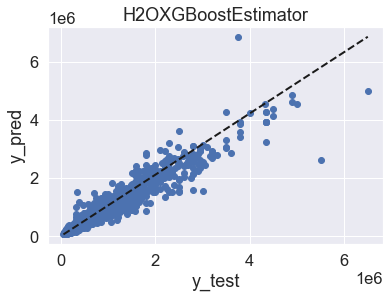

In [133]:
# Plots
y_pred = predict.as_data_frame()
y_test = test[-1].as_data_frame()
plt.figure()
plt.title("H2OXGBoostEstimator")
plt.scatter(y_test,y_pred)
plt.plot([y_test.min(), y_test.max()], [y_pred.min(), y_pred.max()], 'k--', lw=2)
plt.xlabel("y_test")
plt.ylabel("y_pred")

In [ ]:
# Los datos están algo más concentrados, pero sigue existiendo dispersión.
# La gran mayoría de las viviendas están valoradas por debajo de su precio.

In [134]:
print(predict, test[-1])

predict
98479.4
119888
106112
102520
151294
112805
121228
262300
140808
281378


buy_price
109900
118000
90000
89900
144900
110000
138000
280000
100000
275000


In [ ]:
# A pesar del overfitting de este último modelo, y analizando los plots comparativos de precios.
# parece que el modelo que más parece ajustarse es el H2OXGBoostEstimator().

## Tasación manual.

In [87]:
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut
from sklearn import preprocessing

In [88]:
vivienda = {'neighborhood_id': "Malasaña-Universidad, Centro(Madrid)", # Uno del desplegable.
            'is_renewal_needed': True,     # True or False.
            'is_new_development': False,    # True or False.
            'm2': 90,              # Valores inferiores a 140m2.
            'n_rooms': 2,                   # Valores inferiores a 3.
            'n_bathrooms': 2,               # Valores inferiores a 2.
            'floor': 2,                     # Del bajo a la 9ª planta.
            'is_exterior': True,            # True or False.
            'has_lift': True,               # True or False.
            'has_parking': True,            # True or False.
            'has_storage_room': True,       # True or False.
            'has_terrace': True,            # True or False.
            'has_balcony': True,            # True or False.
            'has_pool': True              # True or False.        
           }

In [89]:
geolocator = Nominatim(user_agent="http")

locate = geolocator.geocode(vivienda["neighborhood_id"], timeout=7)
vivienda["latitude"] = locate.latitude
vivienda["longitude"] = locate.longitude

In [90]:
vivienda.pop("neighborhood_id")

'Malasaña-Universidad, Centro(Madrid)'

In [91]:
piso = pd.DataFrame.from_dict(vivienda, orient='index').T
piso

,is_renewal_needed,is_new_development,m2,n_rooms,n_bathrooms,floor,is_exterior,has_lift,has_parking,has_storage_room,has_terrace,has_balcony,has_pool,latitude,longitude
0,True,False,90,2,2,2,True,True,True,True,True,True,True,40.4267,-3.70423


In [92]:
def transf(column):

    le = preprocessing.LabelEncoder()
    piso[column] = le.fit_transform(piso[column])
    return piso[column]

In [93]:
transf("is_renewal_needed")
transf("is_new_development")
transf("is_exterior")
transf("has_lift")
transf("has_parking")
transf("has_storage_room")
transf("has_terrace")
transf("has_balcony")
transf("has_pool");

In [94]:
piso.to_csv("..\outputs\new_piso_all_data.csv")

In [95]:
piso = h2o.import_file("..\outputs\new_piso_all_data.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [96]:
estimated_price = xgbm_h2o.predict(piso)
print(estimated_price)

xgboost prediction progress: |████████████████████████████████████████████| 100%


/usr/local/lib/python3.8/site-packages/h2o/job.py:70: UserWarning: Test/Validation dataset is missing column 'house_type_id': substituting in a column of NaN
  warnings.warn(w)


predict
466930


## Los datos no se ajustan mucho, ni en RMSE, ni en R2. Vamos a realizar un nuevo análisis eliminando outliers que nos puedan estar afectando a la hora de predecir los precios.